In [175]:
# import modules we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns
#sns.set()

from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import datetime


import sklearn
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor

In [176]:
# download stock price dataset we want to predict
stock_name = 'JPM'
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2019, 9, 6)

yf.pdr_override(stock_name)
df_full = pdr.get_data_yahoo(stock_name, start=start, end=end).reset_index()
df_full.to_csv(stock_name+'.csv',index=False)
df_full.head()

[*********************100%***********************]  1 of 1 downloaded


,Date,High,Low,Open,Close,Volume,Adj Close
0,2018-01-02,108.019997,106.809998,107.629997,107.949997,13578800.0,103.156837
1,2018-01-03,108.489998,107.480003,107.860001,108.059998,11901000.0,103.261963
2,2018-01-04,110.029999,108.199997,108.360001,109.040001,12953700.0,104.741249
3,2018-01-05,109.550003,107.779999,109.260002,108.339996,14155000.0,104.068840
4,2018-01-08,108.680000,107.699997,108.150002,108.500000,12466500.0,104.222534


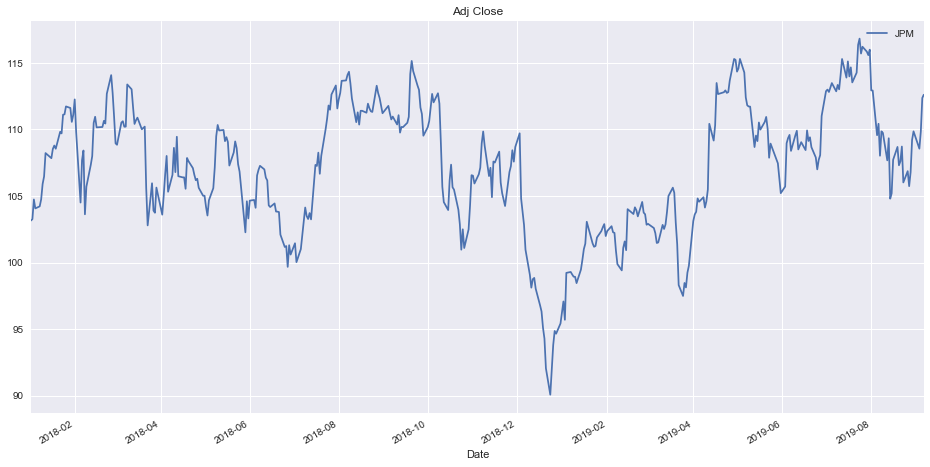

In [177]:
#fig = plt.plot()

#plt.legend([stock_name, stock_name+"_MA"]);

df_full.set_index('Date', inplace=True)
df_raw = df_full[df_full.columns[-1]]
df_raw.plot(label=stock_name, figsize=(16,8), title=df_full.columns[-1], grid=True, legend=True)

## <font color="blue">Explore dataset with Moving Average and Return Deviation<font>
#### Moving Average (MA) smooths out data by continuously updateing averaged data. It is useful to cut down “noise” in our stock price chart.
* $MA = \frac{1}{w}\Sigma_{t=1}^w\ Price_t$ for $t = 1, 2, \dots ,(T-w)$, where:
    * $w$ is sliding window size
    * $T$ is the total number of days ( size of price data )
    
#### Return Deviation is used to determine risk and return
* $Return = \frac{Price_t - Price_{(t-1)}}{Price_{(t-1)}} = \frac{Price_t}{Price_{(t-1)}}-1$

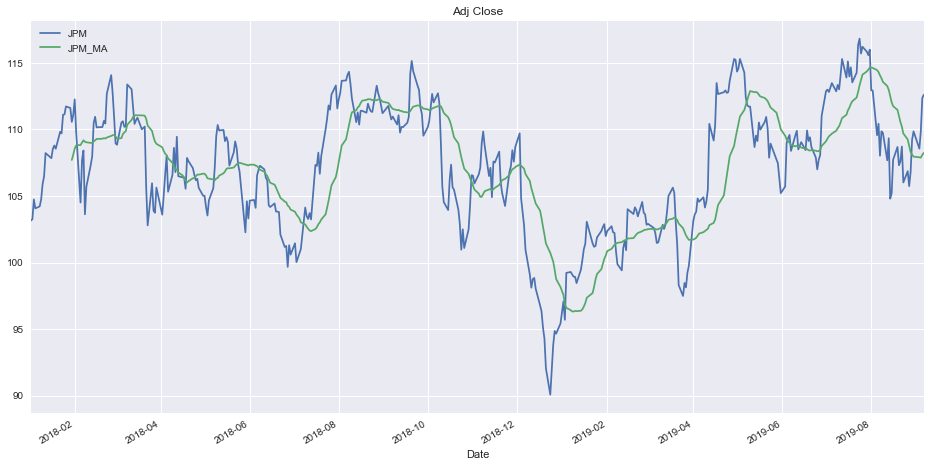

In [178]:
# plot moving average
window = 20
df_MA = df_full[df_full.columns[-1]].rolling(window).mean()
df_raw.plot(label=stock_name, figsize=(16,8), title=df_full.columns[-1], grid=True, legend=True)
df_MA.plot(label=stock_name+'_MA', figsize=(16,8), title=df_full.columns[-1], grid=True, legend=True)

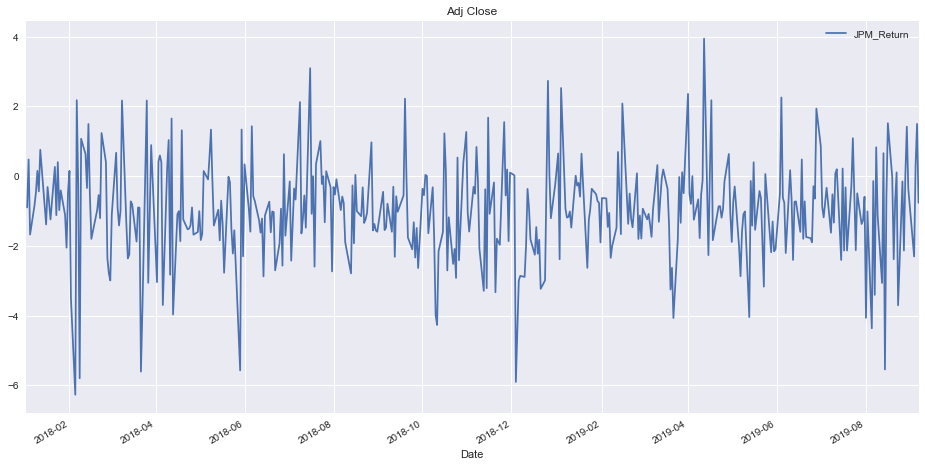

In [179]:
# plot return deviation
df_ret = df_full[df_full.columns[-1]] - df_full[df_full.columns[-1]].shift(1) - 1
df_ret.plot(label=stock_name+'_Return', figsize=(16,8), title=df_full.columns[-1], grid=True, legend=True)

## <font color="blue">Training regression models to predict stock price<font>
### Using scikit-learn packages
Here we use scikit-learn packages to train our regression models, including models like:
* Linear regression
* Ridge regression
* Lasso
* KNN regression

### Date pre-process: Train/Test split
We won't do feature engineering in this project, but typically you need to do it if you use machine learning models instead of deep learning models.
* The input feaures we use here are: **high, low, open, close, volume**
* The output value is **adj close price**

In order to check the generalizing ability of our machine learning models, we have to split dataset into 2 parts: traing and testing set. Typically, we pick a ratio, say 80%, as traing set size over the total data size. The remaining 20% is therefore the testing set. Then, one natural method is to randomly shuffle the dataset and split into training and testing sets. However, for the **time sequence data, we won't split like this since the sequence order matters!** 

What we will do is choose 80% data in the front as training set and 20% data in the rear as testing set. If you randomly shuufle the data, **it is kind of using the future to predict the past**, which is not gonna happened in reality.

In [180]:
# train/test split

X = df_full.iloc[:,:-1].to_numpy() 
y = df_full.iloc[:,-1].to_numpy() 

num_data = df_full.shape[0]
split_ratio = 0.8
ind_split = int(split_ratio * num_data)

X_train = X[:ind_split]
y_train = y[:ind_split].reshape(-1,1)
X_test = X[ind_split:]
y_test = y[ind_split:].reshape(-1,1)

split_time = df_full.index[ind_split]

Training RMSE is: 0.944435
Testing RMSE is: 2.698933


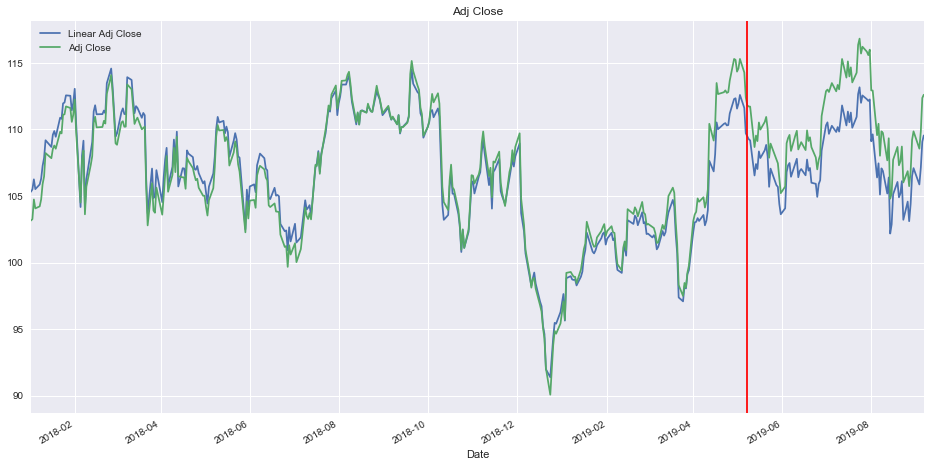

In [181]:
# build Linear regression model
# training
reg_linear = LinearRegression()
reg_linear.fit(X_train, y_train)

# testing
trainings = reg_linear.predict(X_train).reshape(-1,1)
predictions = reg_linear.predict(X_test).reshape(-1,1)

# combine all predictions
all_pred = np.concatenate((trainings, predictions), axis=0)

# transform to dataframe for plotting
df_linear = pd.DataFrame(all_pred, columns=['Linear '+df_full.columns[-1]], index=df_full.index)
df_linear[df_full.columns[-1]] = y

# plot results and add train/test split timing line
df_linear.plot(label=stock_name+'_Linear', figsize=(16,8), title=df_full.columns[-1], grid=True, legend=True)
plt.axvline(pd.Timestamp(split_time),color='r')

# calculate RMSE using vectorization
train_rmse = np.sqrt(1/X_train.shape[0]*np.squeeze(np.dot((trainings - y_train).T, (trainings - y_train))))
test_rmse = np.sqrt(1/X_test.shape[0]*np.squeeze(np.dot((predictions - y_test).T, (predictions - y_test))))

print("Training RMSE is: %f" % train_rmse)
print("Testing RMSE is: %f" % test_rmse)

df_rmse = pd.DataFrame([train_rmse, test_rmse], columns=['Linear'], index=['training', 'testing'])

Training RMSE is: 0.944438
Testing RMSE is: 2.698780


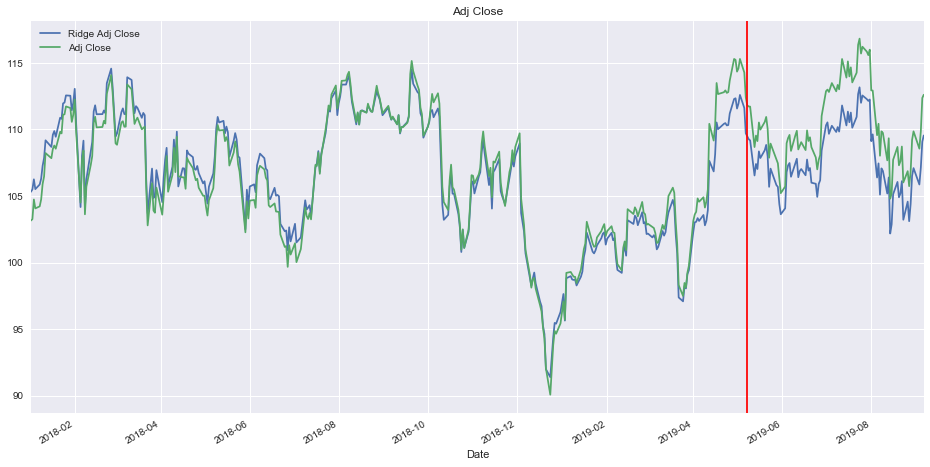

In [182]:
# build Ridge regression model
# training
reg_ridge = Ridge(alpha=.5)
reg_ridge.fit(X_train, y_train)

# testing
trainings = reg_ridge.predict(X_train).reshape(-1,1)
predictions = reg_ridge.predict(X_test).reshape(-1,1)

# combine all predictions
all_pred = np.concatenate((trainings, predictions), axis=0)

# transform to dataframe for plotting
df_ridge = pd.DataFrame(all_pred, columns=['Ridge '+df_full.columns[-1]], index=df_full.index)
df_ridge[df_full.columns[-1]] = y

# plot results and add train/test split timing line
df_ridge.plot(label=stock_name+'_Ridge', figsize=(16,8), title=df_full.columns[-1], grid=True, legend=True)
plt.axvline(pd.Timestamp(split_time),color='r')

# calculate RMSE using vectorization
train_rmse = np.sqrt(1/X_train.shape[0]*np.squeeze(np.dot((trainings - y_train).T, (trainings - y_train))))
test_rmse = np.sqrt(1/X_test.shape[0]*np.squeeze(np.dot((predictions - y_test).T, (predictions - y_test))))

print("Training RMSE is: %f" % train_rmse)
print("Testing RMSE is: %f" % test_rmse)

df_rmse['Ridge'] = [train_rmse, test_rmse]

Training RMSE is: 0.951549
Testing RMSE is: 2.671232


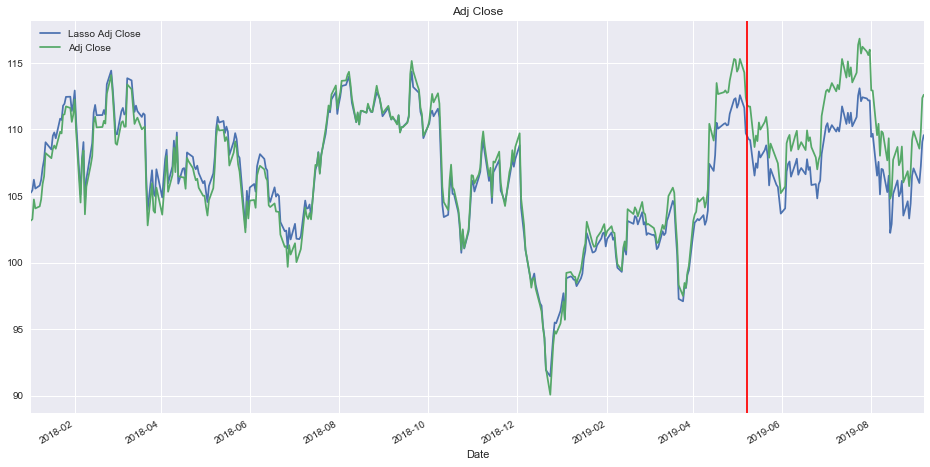

In [183]:
# build Lasso regression model
# training
reg_lasso = Lasso(alpha=0.1)
reg_lasso.fit(X_train, y_train)

# testing
trainings = reg_lasso.predict(X_train).reshape(-1,1)
predictions = reg_lasso.predict(X_test).reshape(-1,1)

# combine all predictions
all_pred = np.concatenate((trainings, predictions), axis=0)

# transform to dataframe for plotting
df_lasso = pd.DataFrame(all_pred, columns=['Lasso '+df_full.columns[-1]], index=df_full.index)
df_lasso[df_full.columns[-1]] = y

# plot results and add train/test split timing line
df_lasso.plot(label=stock_name+'_Lasso', figsize=(16,8), title=df_full.columns[-1], grid=True, legend=True)
plt.axvline(pd.Timestamp(split_time),color='r')

# calculate RMSE using vectorization
train_rmse = np.sqrt(1/X_train.shape[0]*np.squeeze(np.dot((trainings - y_train).T, (trainings - y_train))))
test_rmse = np.sqrt(1/X_test.shape[0]*np.squeeze(np.dot((predictions - y_test).T, (predictions - y_test))))

print("Training RMSE is: %f" % train_rmse)
print("Testing RMSE is: %f" % test_rmse)

df_rmse['Lasso'] = [train_rmse, test_rmse]

Training RMSE is: 3.965751
Testing RMSE is: 5.013361


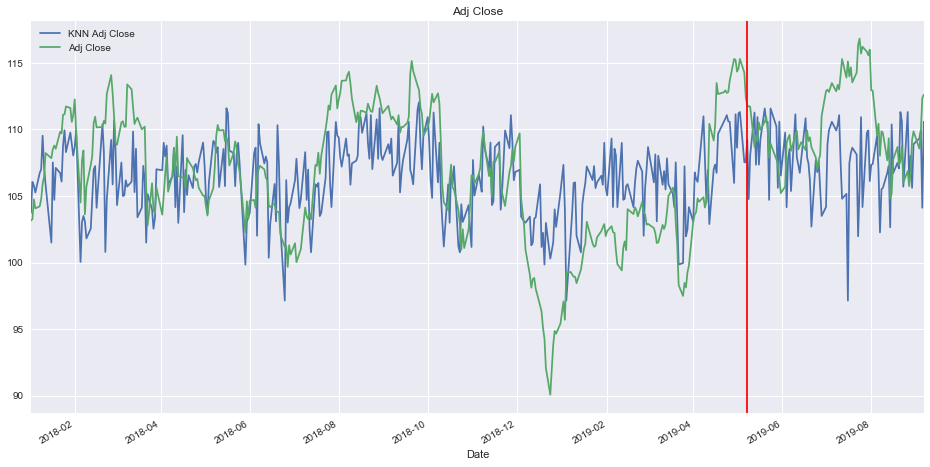

In [184]:
# build KNN regression model
# training
reg_knn = KNeighborsRegressor(n_neighbors=4)
reg_knn.fit(X_train, y_train)

# testing
trainings = reg_knn.predict(X_train).reshape(-1,1)
predictions = reg_knn.predict(X_test).reshape(-1,1)

# combine all predictions
all_pred = np.concatenate((trainings, predictions), axis=0)

# transform to dataframe for plotting
df_knn = pd.DataFrame(all_pred, columns=['KNN '+df_full.columns[-1]], index=df_full.index)
df_knn[df_full.columns[-1]] = y

# plot results and add train/test split timing line
df_knn.plot(label=stock_name+'_KNN', figsize=(16,8), title=df_full.columns[-1], grid=True, legend=True)
plt.axvline(pd.Timestamp(split_time),color='r')

# calculate RMSE using vectorization
train_rmse = np.sqrt(1/X_train.shape[0]*np.squeeze(np.dot((trainings - y_train).T, (trainings - y_train))))
test_rmse = np.sqrt(1/X_test.shape[0]*np.squeeze(np.dot((predictions - y_test).T, (predictions - y_test))))

print("Training RMSE is: %f" % train_rmse)
print("Testing RMSE is: %f" % test_rmse)

df_rmse['KNN'] = [train_rmse, test_rmse]

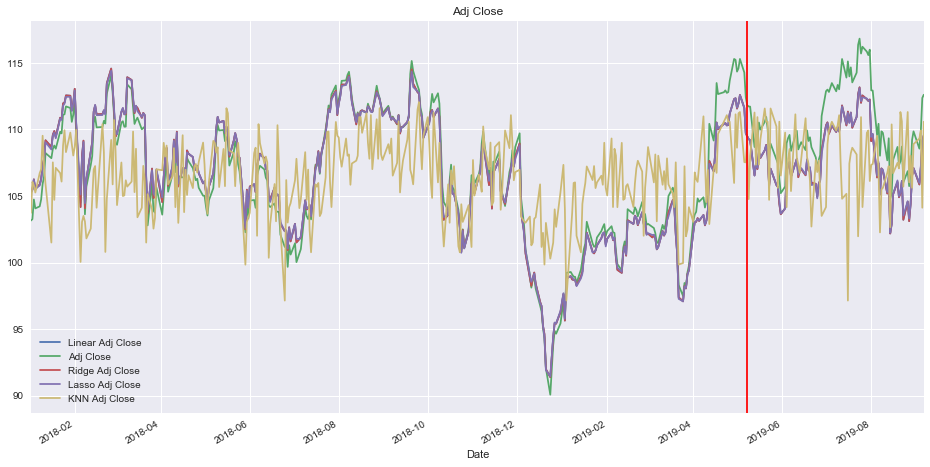

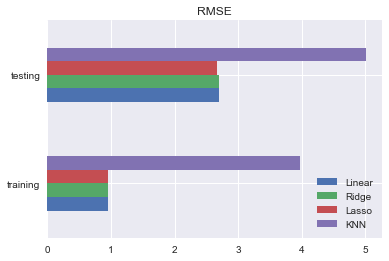

In [185]:
# visualize all models in one plot
df_all = df_linear
df_all[df_ridge.columns[0]] = df_ridge[df_ridge.columns[0]]
df_all[df_lasso.columns[0]] = df_lasso[df_lasso.columns[0]]
df_all[df_knn.columns[0]] = df_knn[df_knn.columns[0]]

# plot results and add train/test split timing line
df_all.plot(label=stock_name, figsize=(16,8), title=df_all.columns[1], grid=True, legend=True)
plt.axvline(pd.Timestamp(split_time),color='r')

df_rmse.plot(kind='barh', title='RMSE')

From these results, we can observe Lasso regression have lowest RMSE in testing set.